### import libraries

In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout,BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam ,RMSprop
import matplotlib.pyplot as plt

### Path

In [2]:
base_dir = r"C:\Users\user\Desktop\Study\3,1\image\project\image process\imagedata"

train_dir = os.path.join(base_dir, 'ttrain')
valid_dir = os.path.join(base_dir, 'dev')
test_dir = os.path.join(base_dir, 'test')

# ImageDataGenerator 
train_datagen = ImageDataGenerator(rescale=1./255)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, 
                                                    class_mode='binary', shuffle=True)
validation_generator = valid_test_datagen.flow_from_directory(valid_dir, target_size=(150, 150), 
                                                             batch_size=32, class_mode='binary', shuffle=True)
test_generator = valid_test_datagen.flow_from_directory(test_dir, target_size=(150, 150), 
                                                        batch_size=32, class_mode='binary', shuffle=False)


Found 140 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


### image enhancement function

In [3]:
def sobel_filter(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # detect horizontal edges
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3) 
    
    # detect vertical edges
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)  
    
    # combine edges from both directions
    sobel_combined = cv2.magnitude(sobel_x, sobel_y)
    sobel_combined = np.uint8(sobel_combined)
    return sobel_combined

def negative_image(image):
    return cv2.bitwise_not(image)
def show_images(original,sobel, enhanced):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(sobel, cv2.COLOR_BGR2RGB))
    plt.title("Sobel Filter")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
    plt.title("Enhanced Image ")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
def enhance_image(image_path):
    sobel_result = sobel_filter(image_path)
   # convert the enhanced image to a negative
    negative_img = negative_image(sobel_result)
    return sobel_result,negative_img


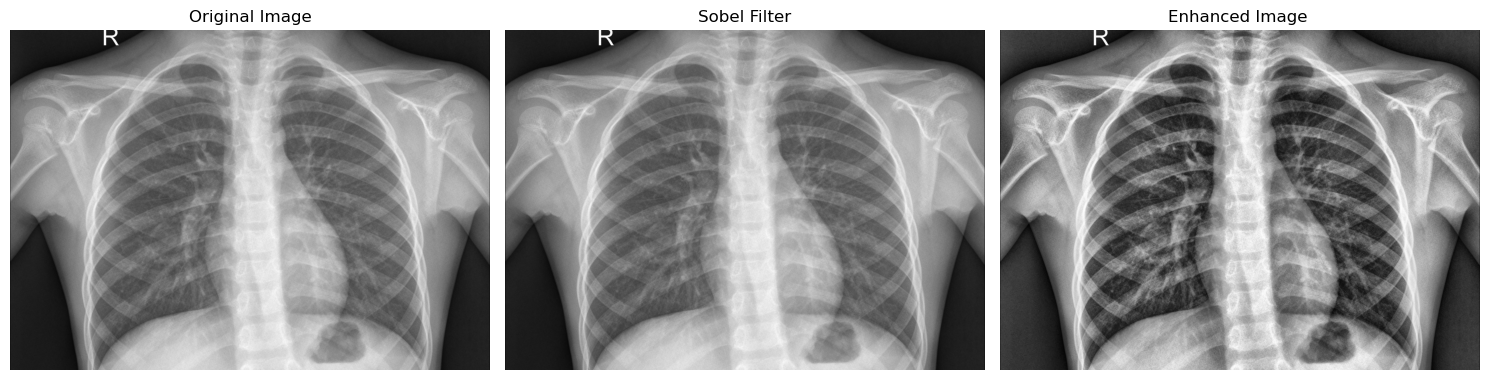

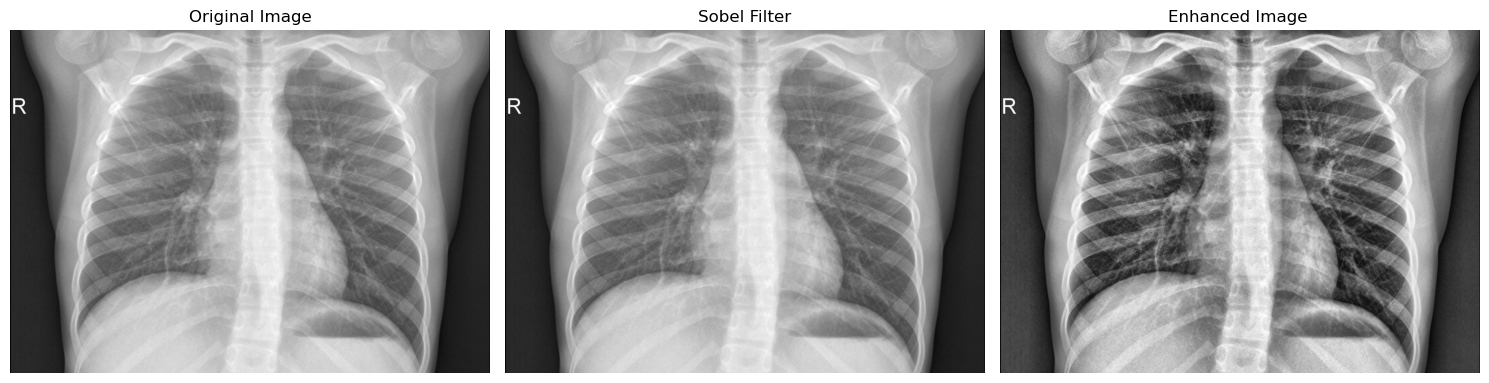

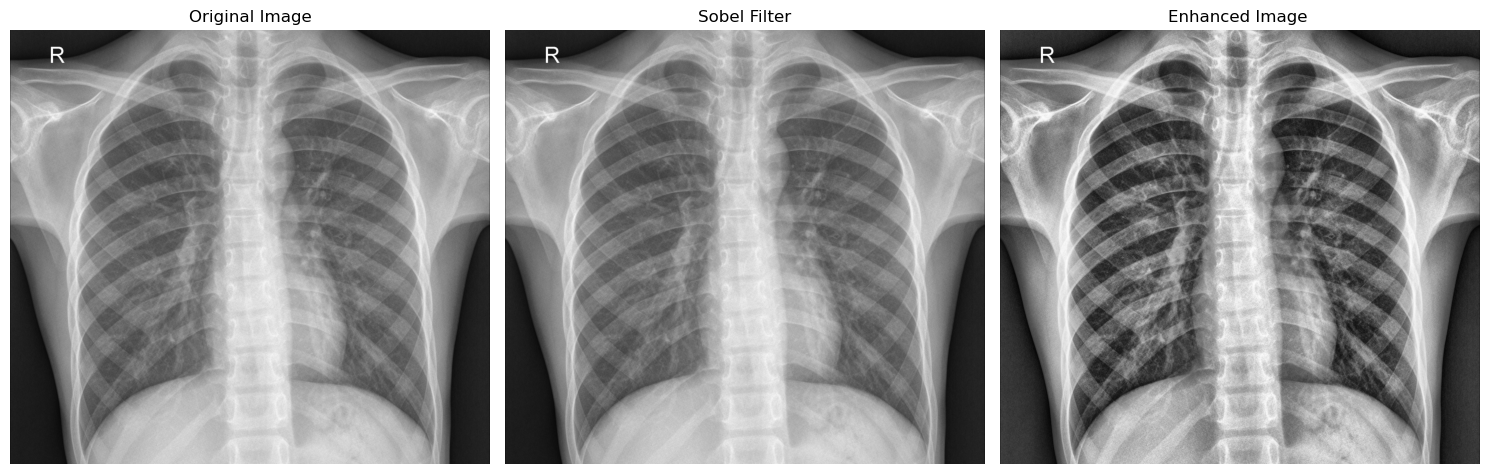

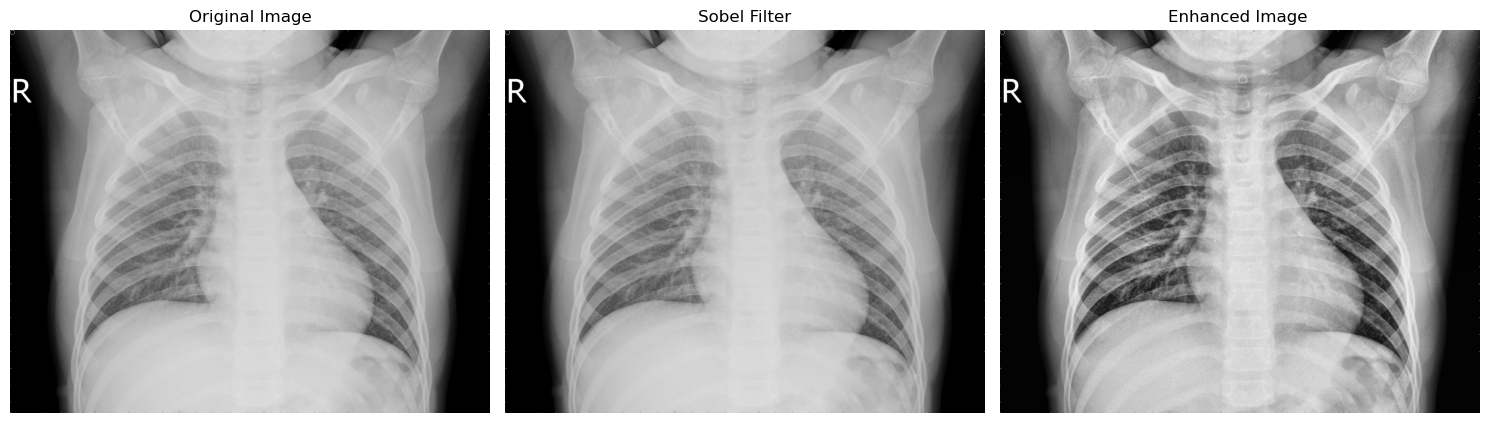

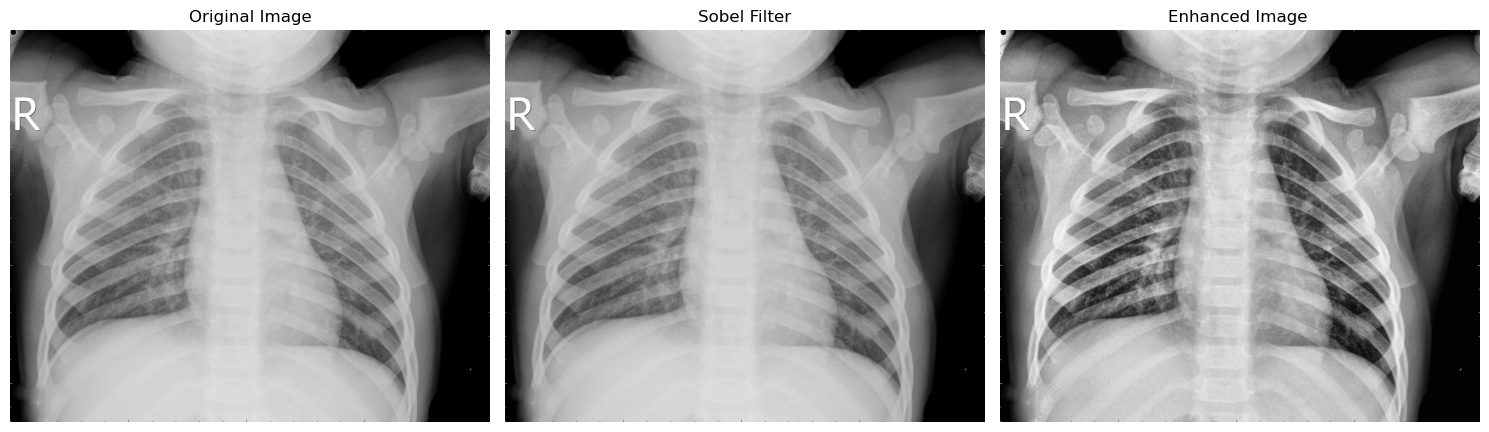

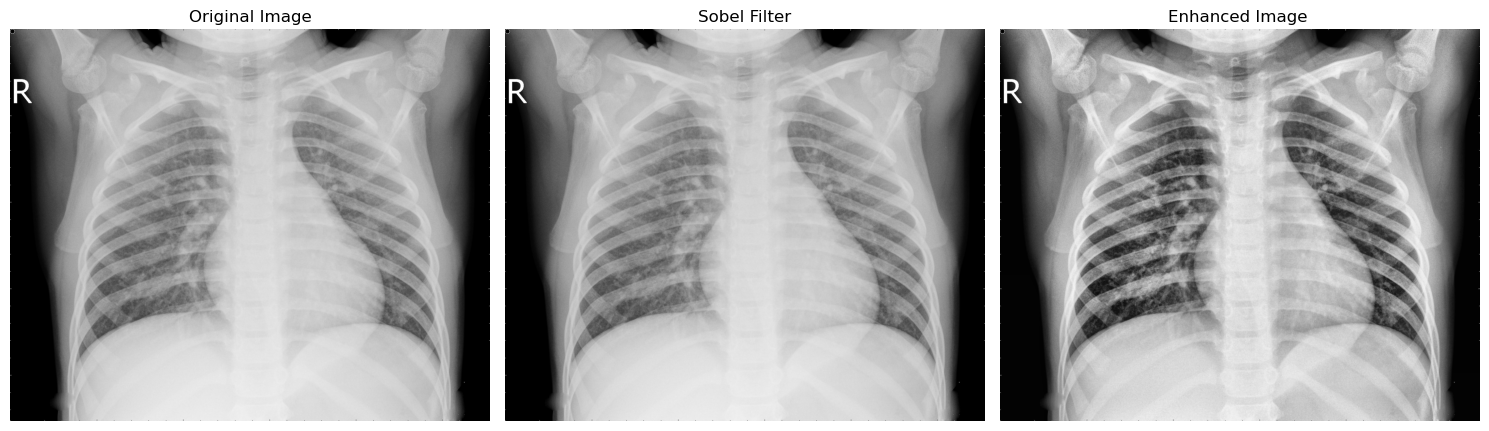

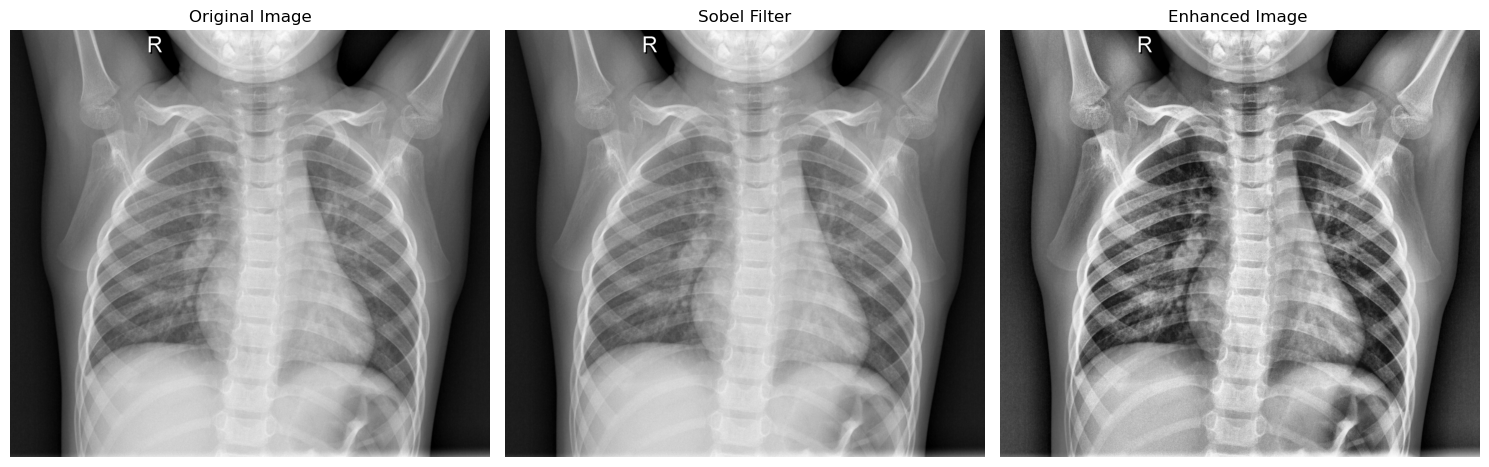

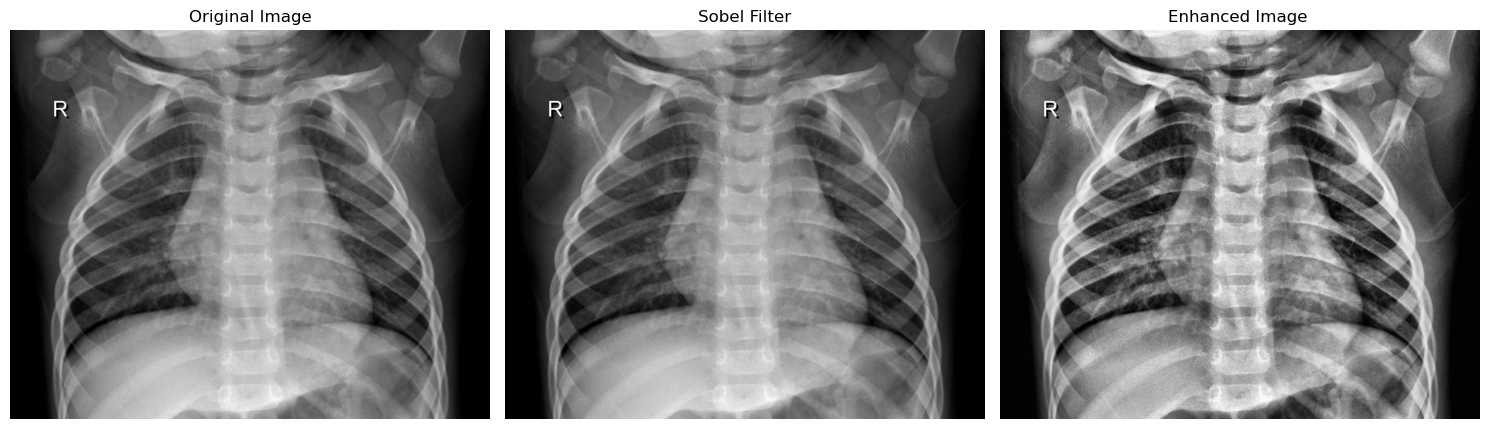

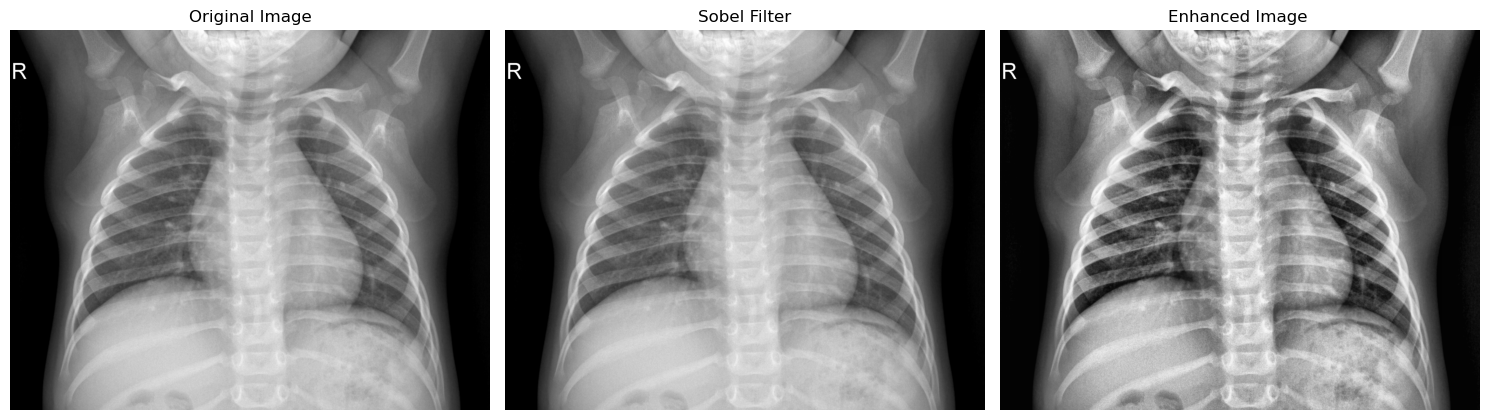

In [4]:
import cv2
import numpy as np
import os

def apply_clahe(image_path):
    # قراءة الصورة باللون الرمادي
    gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # تحسين التباين باستخدام CLAHE (Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(gray_image)

    return gray_image, enhanced_image

def process_and_save_images(directory, show_limit=3):
    processed_dir = directory + "_enhanced"  # مجلد جديد للصورة المحسنة
    os.makedirs(processed_dir, exist_ok=True)
    
    shown_images = 0  # عداد الصور المعروضة
    
    for class_name in os.listdir(directory):  # التكرار عبر الفئات
        class_path = os.path.join(directory, class_name)
        class_processed_path = os.path.join(processed_dir, class_name)
        os.makedirs(class_processed_path, exist_ok=True)
        
        for image_name in os.listdir(class_path):  # التكرار عبر الصور
            image_path = os.path.join(class_path, image_name)
            gray_image, enhanced_image = apply_clahe(image_path)  # تطبيق CLAHE فقط
            
            # حفظ الصورة المحسنة
            cv2.imwrite(os.path.join(class_processed_path, image_name), enhanced_image)
            
            # عرض الصور إذا لم يتم الوصول إلى الحد
            if shown_images < show_limit:
                original_image = cv2.imread(image_path)  # تحميل الصورة الأصلية
                show_images(original_image, gray_image, enhanced_image)  # عرض الصور
                shown_images += 1

# تطبيق المعالجة على مجموعات التدريب، التحقق، واختبار الصور
process_and_save_images(train_dir)
process_and_save_images(valid_dir)
process_and_save_images(test_dir)


### VGG5

In [5]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)  

model = Model(inputs=base_model.input, outputs=x)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=RMSprop(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator) // 16,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator) // 16
)


c:\Users\user\anaco\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - accuracy: 0.4683 - loss: 0.7123 - val_accuracy: 0.6250 - val_loss: 0.6920
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 7s/step - accuracy: 0.6602 - loss: 0.6534 - val_accuracy: 0.5625 - val_loss: 0.6824
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 6s/step - accuracy: 0.7715 - loss: 0.6151 - val_accuracy: 0.6250 - val_loss: 0.6720
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.8335 - loss: 0.5934 - val_accuracy: 0.6250 - val_loss: 0.6634
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.7910 - loss: 0.5851 - val_accuracy: 0.6250 - val_loss: 0.6596
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.8496 - loss: 0.5645 - val_accuracy: 0.5625 - val_loss: 0.6607
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step - accuracy: 0.9029 - loss: 0.5413 - val_accuracy: 0.5625 - val_loss: 0.6605
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.8402 - loss: 0.5335 - val_accuracy: 0.5625 - val_loss: 0.6870
Epoch 9/

### Test 

In [6]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8479 - loss: 0.5663
Test Loss: 0.5569310188293457
Test Accuracy: 0.8500000238418579
